<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/355_groups_comparison.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(groups_comparison_notebook)=
# Gruppi multipli

L'obiettivo del presente capitolo è di estendere la discussione iniziata nel capitolo {ref}`bayes_one_mean_notebook`, focalizzandoci sull'analisi comparativa delle medie di più gruppi indipendenti. Inizieremo importando le librerie necessarie.

## Preparazione del notebook

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import pymc.sampling_jax
import xarray as xr
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In questo tutorial useremo i dati relativi ai pinguini Palmer, che verranno letti da un file csv, escludendo le osservazini che presentano valori mancanti:

In [3]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

## EDA

Otteniamo in questo modo un DataFrame con 333 righe e 8 colonne. 

In [4]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Nella discussione seguente ci focalizzeremo sul peso `body_mass_g` in funzione della specie:

In [5]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Creiamo un grafico a violino per questi dati.

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


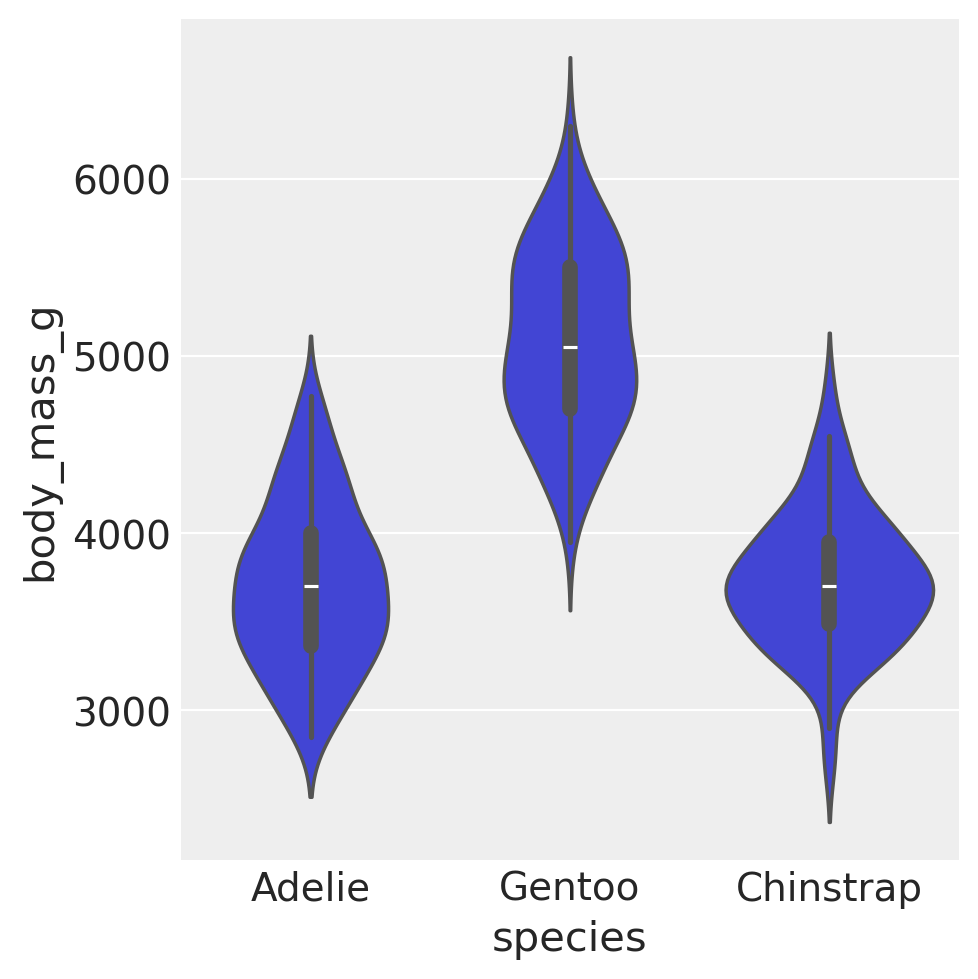

In [6]:
sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")
plt.show()

## Modellizzazione bayesiana

La stima della media e della varianza ottenuta da un campione di osservazioni non è rappresentativa dell'intera popolazione di pinguini. Ci chiediamo, quindi, quale sia l'incertezza associata alla stima del peso per le tre specie di pinguini, considerando che abbiamo a disposizione solo un piccolo campione di osservazioni. Per fare ciò, dobbiamo definire un modello statistico che descriva la relazione tra i dati e i parametri. Nel nostro caso, descriviamo la distribuzione a posteriori dei parametri, tenendo conto dei dati, come segue:

$$
p(\mu, \sigma \mid y) \propto p(y \mid \mu, \sigma) p(\mu)p(\sigma),
$$

dove la verosimiglianza sarà una densità Normale, dipendente da due parametri: $\mu$ e $\sigma$. Inoltre, sarà necessario definire le distribuzioni a priori di questi due parametri.

Consideriamo qui di seguito una possibile soluzione per quantificare l'incertezza della nostra stima mediante l'utilizzo dei metodi bayesiani.

Iniziamo a trovare la media e la deviazione standard di tutte le osservazioni.

In [7]:
[penguins["body_mass_g"].mean(), penguins["body_mass_g"].std()]

[4207.057057057057, 805.2158019428964]

In [8]:
coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}

with pm.Model(coords=coords) as model:
    # Constant data for species indices
    species_idx = pm.ConstantData(
        "species_idx",
        penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
    )

    # Normal priors for mu and sigma for each species
    mu = pm.Normal("mu", 4200, 1000, dims="species")
    sigma = pm.HalfNormal("sigma", 500, dims="species")

    # Likelihood
    y = pm.Normal(
        "y",
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=penguins["body_mass_g"],
    )

Questo modello stima i parametri $ \mu $ e $ \sigma $ (media e deviazione standard) per il peso corporeo (`body_mass_g`) di ciascuna delle tre specie di pinguini ("Adelie", "Gentoo", "Chinstrap"). A seguire, analizzeremo in dettaglio la struttura e la sintassi del modello.

1. **Definizione delle Coordinate**: 
   ```python
   coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}
   ```
   Qui vengono definite le coordinate per la dimensione "species". Nel contesto dei modelli statistici bayesiani realizzati con PyMC, il termine "coordinate" è utilizzato per definire un insieme ordinato di valori che rappresentano le categorie o i livelli di una variabile. Nel caso presente, la variabile d'interesse è "species", e ha tre livelli: "Adelie", "Gentoo", e "Chinstrap".

2. **Creazione del Modello**:
   ```python
   with pm.Model(coords=coords) as model:
   ```
   Viene creato un nuovo modello Bayesiano con le coordinate specificate.

3. **Dati Costanti per Indici delle Specie**:
   ```python
   species_idx = pm.ConstantData(
       "species_idx",
       penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
   )
   ```
   Gli indici per le specie vengono creati e salvati come dati costanti nel modello. Questi indici serviranno per mappare ciascuna osservazione ai parametri specifici della sua specie.

   Gli indici contenuti nella variabile `species_idx` servono per associare ogni osservazione del peso corporeo dei pinguini, rappresentato da `penguins["body_mass_g"]`, alla specie di pinguino corrispondente. Questa informazione viene utilizzata nel calcolo della verosimiglianza nel modello, specificata dalla funzione `pm.Normal`. In altre parole, `species_idx` indica a quale delle tre specie di pinguini (Adelie, Gentoo o Chinstrap) appartiene ciascuna delle 333 osservazioni del dataset.

   Per chiarire il ruolo di `species_idx`, stampiamo questi valori creando un array ad hoc al di fuori di `pm.Model`.

In [9]:
species_idx_values = (
    penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values
)
print(species_idx_values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


4. **Priori per $ \mu $ e $ \sigma $**:

    ```python
    mu = pm.Normal("mu", 4200, 1000, dims="species")
    sigma = pm.HalfNormal("sigma", 500, dims="species")
    ```
    
    In questa sezione del modello, si specificano i priori per i parametri $ \mu $ e $ \sigma $, associandoli a ciascuna delle tre specie di pinguini. Per $ \mu $, si utilizza una distribuzione Normale con una media di 4200 e una deviazione standard di 1000. Per $ \sigma $, si utilizza una distribuzione HalfNormal con un parametro di scala di 500.

    L'uso dell'argomento `dims="species"` indica che si intendono ottenere stime separate di $ \mu $ e $ \sigma $ per ogni specie (Adelie, Gentoo e Chinstrap). In pratica, questo significa che il modello genererà un array di valori per $ \mu $ e $ \sigma $, uno per ogni specie.

    L'argomento `coords`, precedentemente definito come `coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}`, fornisce un ulteriore contesto alla dimensione specificata da `dims`, delineando i tre livelli o categorie specifiche della dimensione "species". Questo dettaglio facilita non solo la modellazione, ma anche l'interpretazione e la visualizzazione dei risultati ottenuti.

5. **Verosimiglianza (Likelihood)**:
   ```python
   y = pm.Normal(
       "y",
       mu=mu[species_idx],
       sigma=sigma[species_idx],
       observed=penguins["body_mass_g"],
   )
   ```
   La verosimiglianza del modello è definita come una distribuzione Normale. Ogni osservazione del peso corporeo è mappata al $ \mu $ e $ \sigma $ corrispondenti alla sua specie, utilizzando gli indici delle specie (`species_idx`).

Generiamo la visualizzazione grafica della struttura del modello.

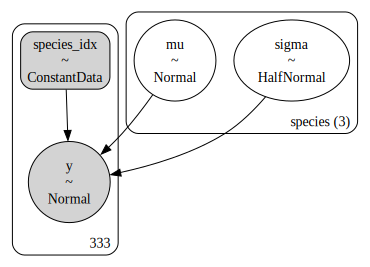

In [10]:
pm.model_to_graphviz(model)

Esaminiamo la distribuzione predittiva a priori.

In [11]:
with model:
    idata_prior = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [mu, sigma, y]


/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_85694/2431238427.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


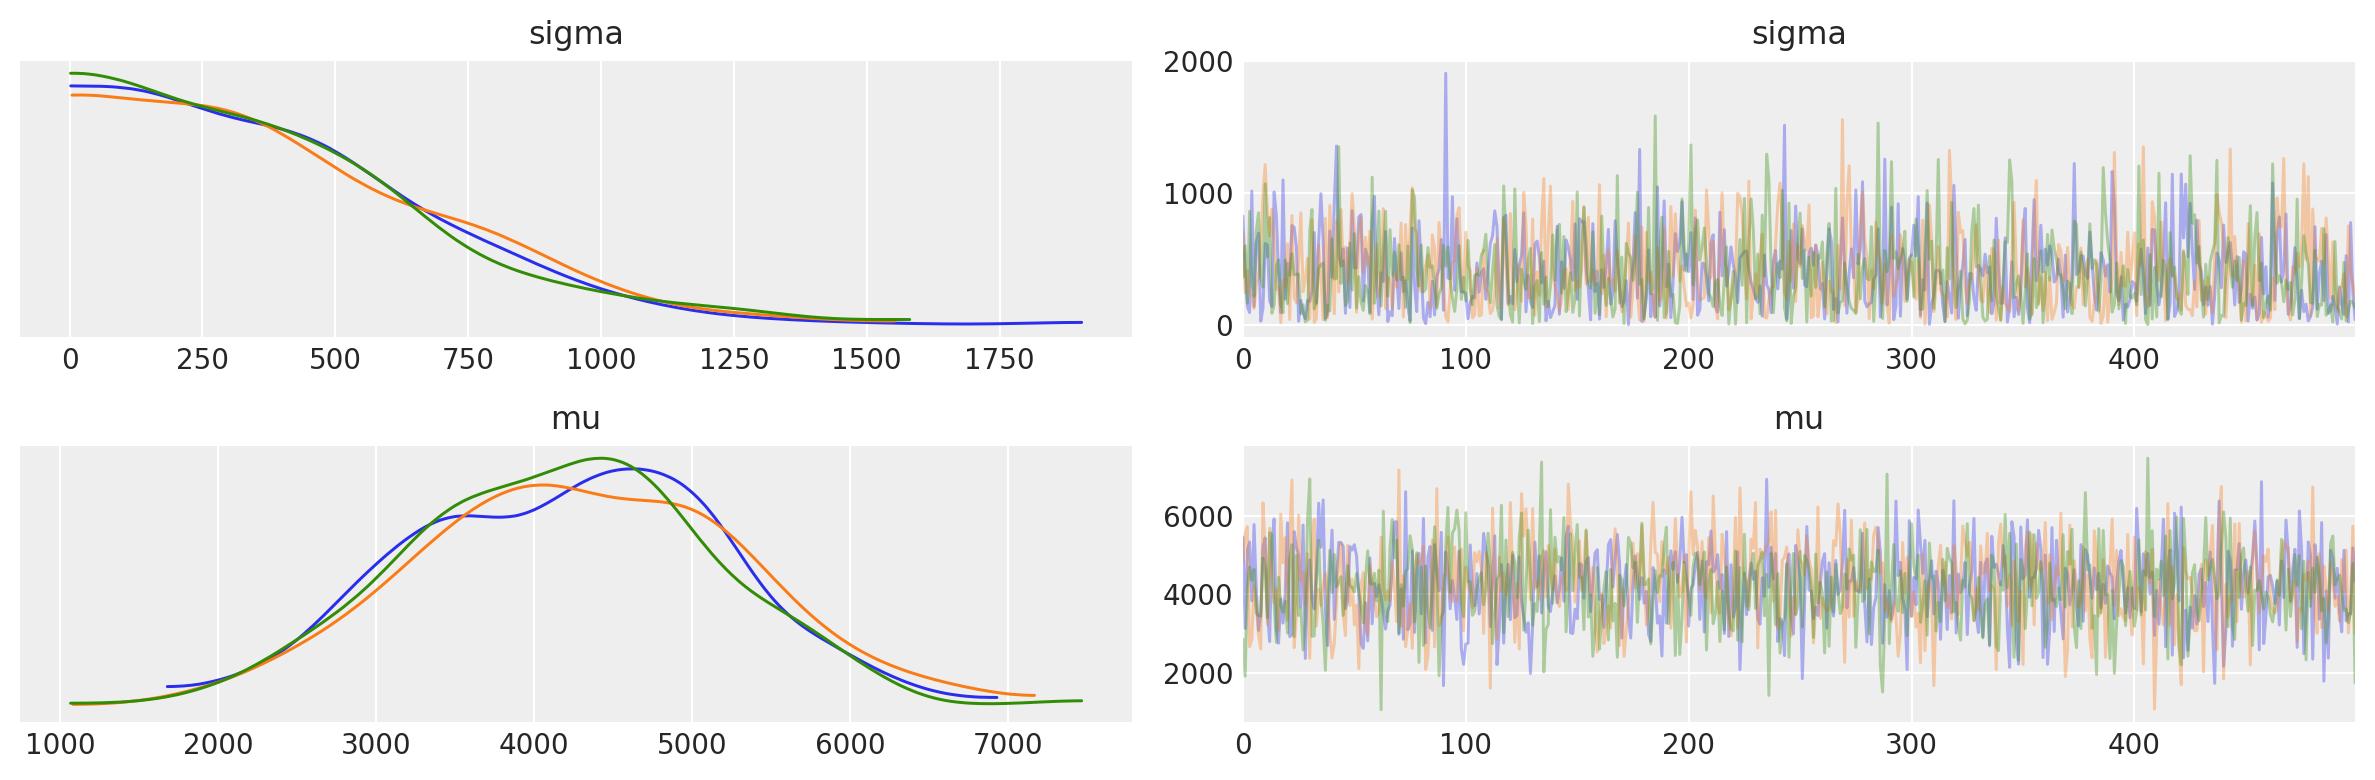

In [12]:
az.plot_trace(idata_prior.prior)
plt.tight_layout()
plt.show()

Eseguiamo il campionamento.

In [13]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


I0000 00:00:1699425694.975541       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
Compilation time = 0:00:08.251773


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   5%|███▍                                                                | 100/2000 [00:01<00:05, 375.79it/s]

Running chain 1:   5%|███▍                                                                | 100/2000 [00:01<00:05, 368.78it/s]

Running chain 0:   5%|███▍                                                                | 100/2000 [00:01<00:05, 338.36it/s]

Running chain 3:   5%|███▍                                                                | 100/2000 [00:01<00:05, 323.04it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1168.18it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1169.21it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1169.92it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1170.81it/s]


Sampling time = 0:00:01.920568


Transforming variables...


Transformation time = 0:00:00.060033


Computing Log Likelihood...


Log Likelihood time = 0:00:00.129812


Esaminiamo le distribuzioni a posteriori e le diagnostiche del campionamento.

/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_85694/2491313140.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


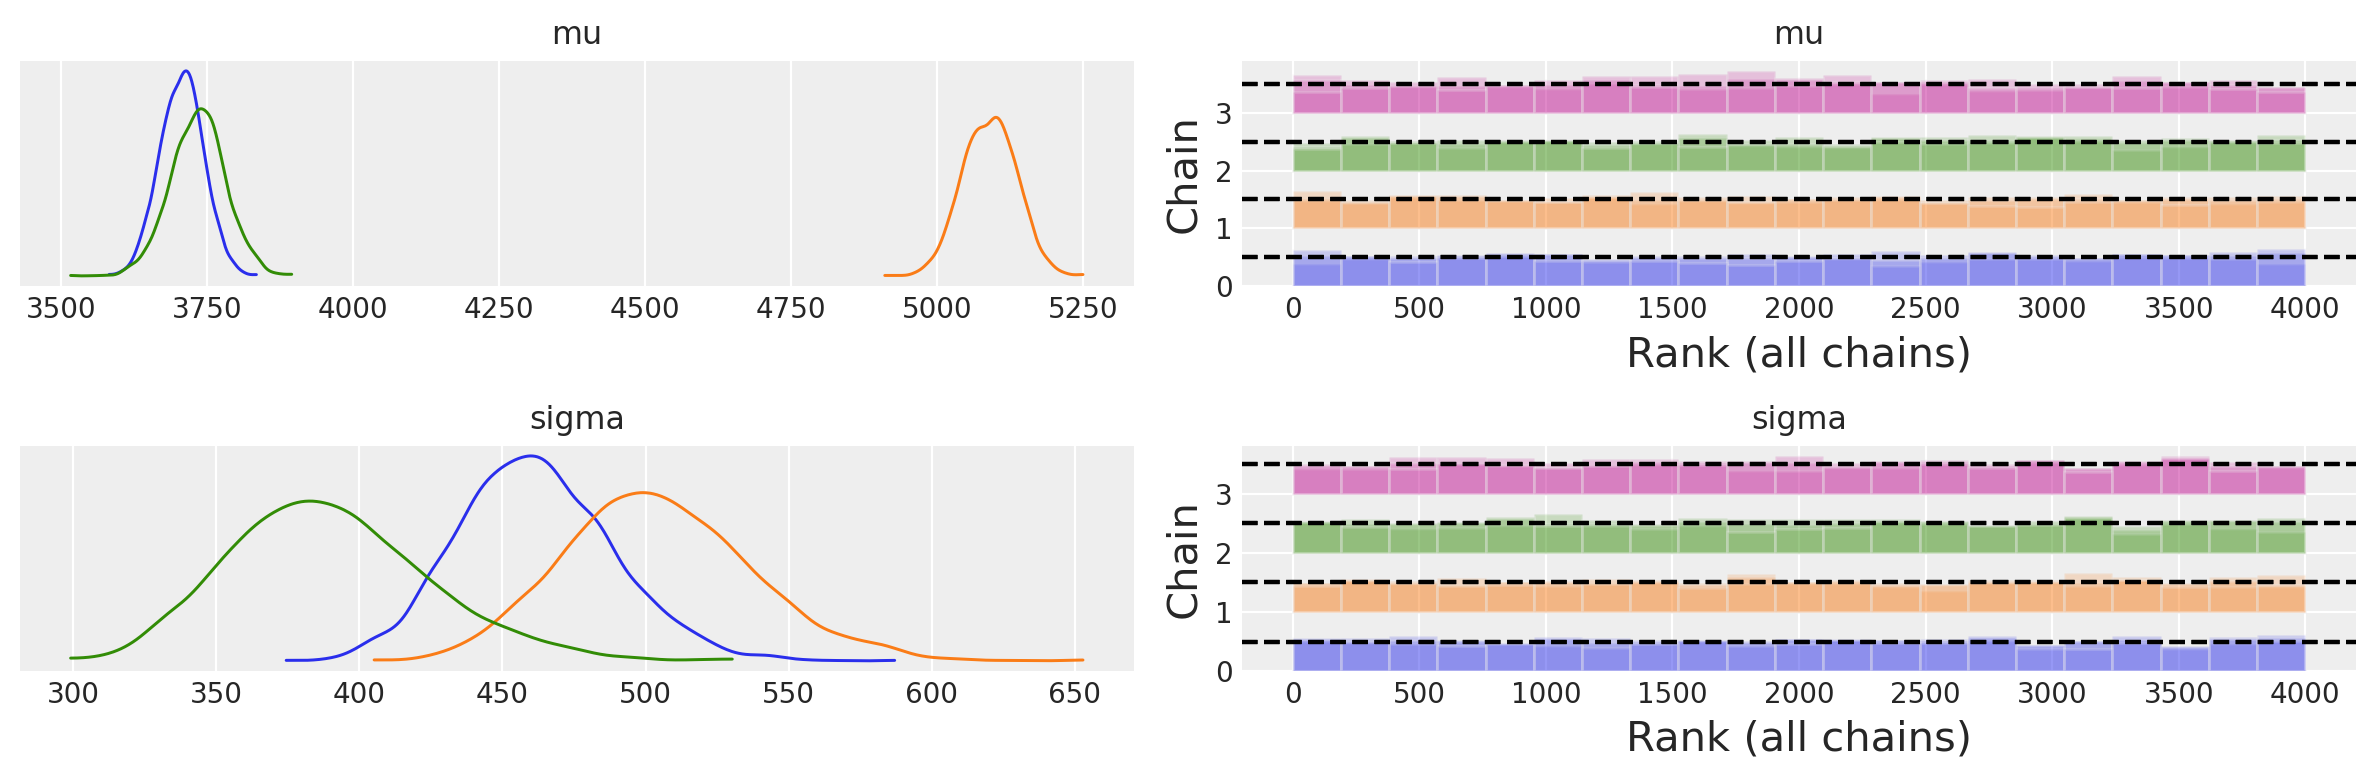

In [14]:
axes = az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

Abbiamo ottenuto tre distribuzioni a posteriori per ciascuno dei due parametri $\mu$ e $\sigma$, una distribuzione per ciascuna specie di pinguini.

Un sommario numerico delle distribuzioni a posteriori si ottiene nel modo seguente.

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Adelie],3706.421,37.172,3639.051,3778.183,0.501,0.354,5504.0,3240.0,1.0
mu[Gentoo],5090.482,46.014,5000.269,5170.022,0.615,0.435,5605.0,3065.0,1.0
mu[Chinstrap],3734.572,46.869,3647.835,3825.924,0.640,0.453,5358.0,3083.0,1.0
sigma[Adelie],461.291,26.874,414.906,516.042,0.341,0.244,6324.0,3436.0,1.0
sigma[Gentoo],504.378,32.777,444.610,567.736,0.442,0.317,5646.0,3000.0,1.0
sigma[Chinstrap],389.184,34.675,327.337,454.780,0.502,0.363,5054.0,2789.0,1.0


Confrontiamo la media a posteriori del parametro $\mu$ con le medie del peso dei tre campioni di pinguini.

In [16]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Nell'analisi bayesiana, le medie a posteriori dei parametri $ \mu $ per ciascuna delle tre specie di pinguini convergono verso le medie campionarie. L'elemento distintivo dell'approccio bayesiano è la quantificazione dell'incertezza associata a queste stime, che qui è espressa attraverso gli intervalli di credibilità al 94%.

Dall'osservazione delle distribuzioni a posteriori e dei corrispondenti intervalli di credibilità, possiamo inferire i seguenti punti:

1. **Similarità tra Adelie e Chinstrap**: Le distribuzioni a posteriori delle medie dei pesi per le specie Adelie e Chinstrap sono largamente sovrapposte. Questo suggerisce che le differenze nel peso medio tra queste due specie non sono statisticamente credibili.

2. **Distinzione dei Gentoo**: Al contrario, la distribuzione a posteriori del peso medio per la specie Gentoo è notevolmente disgiunta da quelle delle altre due specie, indicando che i pinguini Gentoo sono generalmente più pesanti.

3. **Variabilità del Peso**: L'analisi delle distribuzioni a posteriori dei parametri $ \sigma $ rivela che il peso dei pinguini Gentoo presenta una maggiore variabilità, seguito dai pinguini Adelie e infine dai pinguini Chinstrap. Questo è corroborato dall'ampiezza degli intervalli di credibilità per $ \sigma $ nelle tre specie.

In sintesi, l'analisi Bayesiana fornisce non solo una stima puntuale dei parametri di interesse, ma anche una misura robusta dell'incertezza associata a queste stime, permettendo un'interpretazione più completa e informativa dei dati.

## Test d'ipotesi bayesiani

Dopo aver effettuato il campionamento dalla distribuzione a posteriori del parametro $ \mu $ per ogni specie di pinguino, è naturale indagare sulla probabilità che il peso medio di una specie sia maggiore rispetto a un'altra. Questa domanda può essere affrontata mediante l'analisi comparativa delle distribuzioni a posteriori. In particolare, si può procedere estraendo campioni casuali dai posteriori e confrontando le corrispondenti realizzazioni del parametro $ \mu $ tra le diverse specie.

L'ispezione delle proprietà di `idata` fornisce informazioni dettagliate sui campioni a posteriori, che possono essere utilizzate per ulteriori analisi e interpretazioni statistiche.

In [17]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

Recuperiamo i valori a posteriori del parametro $\mu$.

In [18]:
mu_post = idata.posterior['mu']

L'oggetto ottenuto è un array di dimensioni $4 \times 1000 \times 3$. L'indice 4 si riferisce alle catente, l'indice 1000 si riferisce al numero di campioni ottenuti, l'indice 3 si riferisce ai gruppi. 

In [19]:
mu_post.shape

(4, 1000, 3)

Per trovare la media a posteriori del parametro $\mu$ della specie Adelie prendiamo le osservazioni che si riferiscono a tutte le catene (:), a tutti i valori campionati (:) per il primo gruppo (0). La media a posteriori dei pinguini Adelie è dunque uguale a

In [20]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3706.4213697)
Coordinates:
    species  <U9 'Adelie'


Per tutte e tre le specie (Adelie, Gentoo, Chinstrap) abbiamo

In [21]:
np.array(
    [mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()]
).round(1)

array([3706.4, 5090.5, 3734.6])

Confrontiamo questi risultati con le statistiche descrittive del campione.

In [22]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean"])
)
summary_stats.round(1)

,body_mass_g
,mean
species,
Adelie,3706.2
Chinstrap,3733.1
Gentoo,5092.4


Per verificare che l'ordinamento dei gruppi corrisponda a Adelie, Gentoo, Chinstrap, esaminiamo la stima a posteriori della deviazione standard delle tre specie. 

In [23]:
sigma_post = idata.posterior["sigma"]
np.array(
    [sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()]
).round(1)

array([461.3, 504.4, 389.2])

I valori trovati confermano quello che ci aspettavamo. Ora che abbiamo capito come estrarre le stime a posteriori di un parametro per ciascun gruppo, possiamo passare al test di ipotesi bayesiano.
Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Chinstrap.

In [24]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 1]])

1.0

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [25]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.684

Chiediamoci quale sia la probabilità che un pinguino Chinstrap abbia un peso minore di un pinguino Gentoo.

In [26]:
np.mean([mu_post[:, :, 1] < mu_post[:, :, 2]])

0.0

Consideriamo ora la variabilità. Troviamo la probabilità che la deviazione standard del peso dei pinguini Adelie sia minore di quella dei pinguini Chinstrap.

In [27]:
np.mean([sigma_post[:, :, 0] < sigma_post[:, :, 2]])

0.055

## Commenti e considerazioni finali 

In questo capitolo, abbiamo esaminato l'inferenza parametrica applicata a distribuzioni normali in scenari con gruppi di dati indipendenti. Nei capitoli successivi, ci sposteremo verso un quadro analitico diverso, particolarmente pertinente quando si presume che i gruppi in esame siano istanze specifiche di una categoria generale e sottostante. Questa prospettiva è formalizzata attraverso l'uso di modelli gerarchici bayesiani, una metodologia frequentemente impiegata nel campo della psicologia.

## Watermark

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pytensor: 2.13.1

arviz     : 0.16.1
numpy     : 1.25.2
xarray    : 2023.10.1
pymc      : 5.9.1
pandas    : 2.1.1
scipy     : 1.11.3
seaborn   : 0.13.0
matplotlib: 3.8.0

Watermark: 2.4.3

